In [2]:
import sys
sys.path.append('../')
from time import time
import preprocess as pp
from data_input import load_buildings_from_osm, load_roads_from_osm
import metrics
import merge_dfs as md
from data_input import load_gdb_layer
import config_parser
from generate_clusters import get_cgram, add_cluster_col, plot_clusters
from data_output import dataframe_to_gdb

In [3]:

# buildings data (Michael)
params = config_parser.read_config('config.ini')
gdb_bld_path = params['gdb_bld_path']
buildings = load_gdb_layer(gdb_bld_path)

Layers in the selected GDB: ['buildings']


In [4]:
# streets data (OSM)
verbose=True
t0 = time()
place = 'Jerusalem'
local_crs = 'EPSG:2039'
network_type = 'drive'
streets = load_roads_from_osm(place, network_type=network_type)


In [5]:
#Preprocess
streets, junctions = pp.get_streets(streets=streets, local_crs=local_crs, get_juncions=True)
buildings = pp.get_buildings(buildings=buildings, streets=streets, junctions=junctions, local_crs=local_crs, )

tessellations = pp.get_tessellation(buildings=buildings, streets=streets, 
                                        tess_mode='morphometric', clim='adaptive')


No building heights in data


/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/libpysal/graph/base.py:1375: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _gabriel(


Failed creating limit in adaptive mode. Resetting limit to 100


/Users/annarubtsov/Desktop/DSSG/app/preprocess.py:164: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [20500, 20839, 32858].
  collapsed, _ = momepy.verify_tessellation(tessellations, buildings)


In [6]:

### Get metrics
metrics.generate_building_metrics(buildings)
queen_1 = metrics.generate_tessellation_metrics(tessellations, buildings)
metrics.generate_streets_metrics(streets)
queen_3 = metrics.generate_graph_building_metrics(buildings, streets, queen_1)
junctions, streets = metrics.generate_junctions_metrics(streets)


/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/momepy/functional/_shape.py:576: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(90 - degrees[true_angles]))
/Users/annarubtsov/Desktop/DSSG/app/metrics.py:79: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  tessellations['tess_covered_area'] = queen_1.describe(tessellations.area)['sum']
/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/momepy/functional/_distribution.py:382: RuntimeWarning: invalid value encountered i

In [7]:

### Merge dataframes
merged = md.merge_all_metrics(tessellations, buildings, streets, junctions)
metrics_with_percentiles = md.compute_percentiles(merged, queen_3)
standardized = md.standardize_df(metrics_with_percentiles)


corners


/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/momepy/functional/_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()


squareness


/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/momepy/functional/_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()


perimeter
shape_index
circular_compactness
square_compactness
weighted_axis_compactness
courtyard_area
courtyard_index
fractal_dimension
facade_ratio
orientation
longest_axis_length
equivalent_rectangular_index
elongation
rectangularity
shared_walls_length
perimeter_wall
alignment
adjacency
mean_interbuilding_distance
neighbour_distance
courtyards_num
street_alignment
tID
tess_area
tess_circ_compactness
tess_convexity
tess_neighbors
tess_covered_area
tess_build_area_raio
tess_orientation
tess_building_orientation
tess_alignment
tess_equivalent_rect_index
str_orientation
str_longest_axis
str_linearity
str_length
width
openness
width_dev
degree
closeness
cyclomatic
edge_node_ratio
gamma
mean_nd
meanlen
meshedness
node_density
node_density_weighted
straightness


K=1 skipped. Mean computed from data directly.
K=2 fitted in 1.183 seconds.
K=3 fitted in 1.452 seconds.
K=4 fitted in 2.276 seconds.
K=5 fitted in 2.531 seconds.
K=6 fitted in 2.998 seconds.
K=7 fitted in 4.300 seconds.
K=8 fitted in 4.857 seconds.
K=9 fitted in 4.163 seconds.
K=10 fitted in 4.473 seconds.
K=11 fitted in 4.745 seconds.
K=12 fitted in 4.131 seconds.
K=13 fitted in 5.873 seconds.


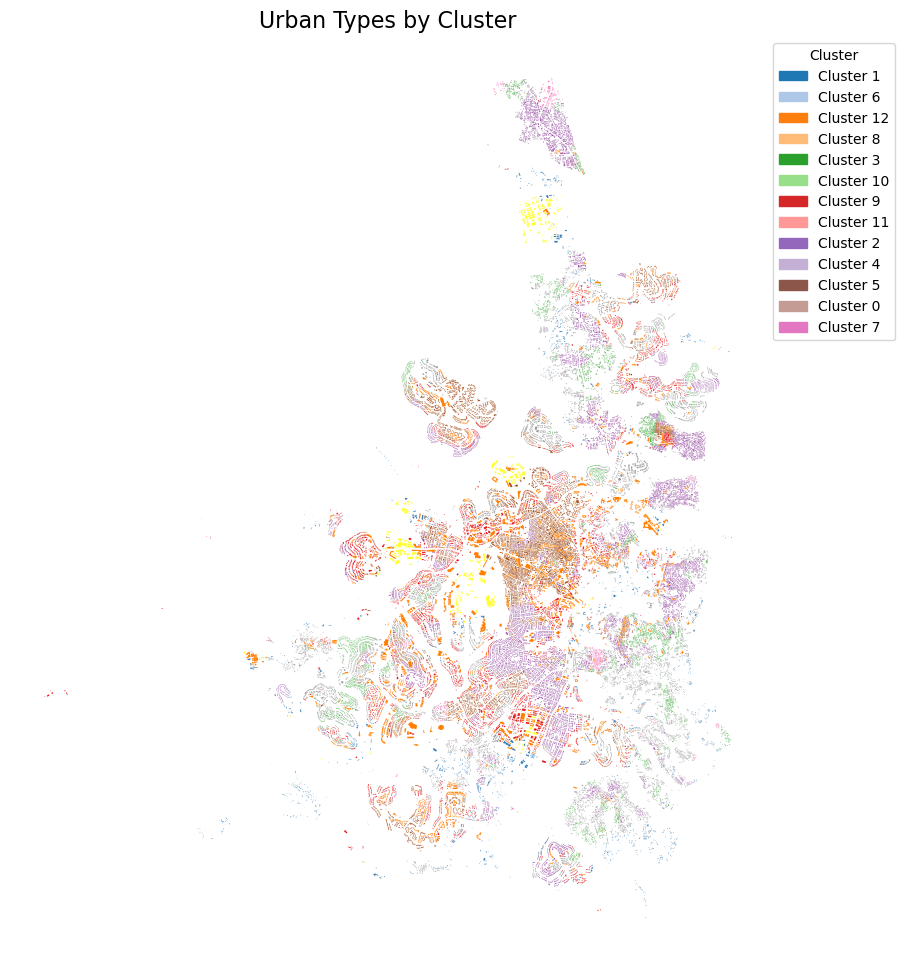

/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field junction_index of type Integer64 will be written as a Float64. To get Integer64, use layer creation option TARGET_ARCGIS_VERSION=ARCGIS_PRO_3_2_OR_LATER
  ogr_write(
/opt/anaconda3/envs/momepy_env/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field corners of type Integer64 will be written as a Float64. To get Integer64, use layer creation option TARGET_ARCGIS_VERSION=ARCGIS_PRO_3_2_OR_LATER
  ogr_write(


Data exported to /Users/annarubtsov/Desktop/DSSG/Michaels_Data/All_Layers/מרקמים/commondata/myproject16.gdb with layer name 'urban_types'


In [8]:


### make clusters
cgram = get_cgram(standardized, 14)
urban_types = add_cluster_col(merged, buildings, cgram, 13)
plot_clusters(urban_types)
dataframe_to_gdb(urban_types, "/Users/annarubtsov/Desktop/DSSG/Michaels_Data/All_Layers/מרקמים/commondata/myproject16.gdb", "urban_types")